In [121]:
%run functions.py

# ES

In [2]:
# load data
benchmarks = ('adpcm_encoder', 'average', 'fir')
asic_45, fpga_v4, fpga_v5 = load_data_all(benchmarks, load_fpga_v5=False)

In [3]:
# combine attr and latency
for i in benchmarks:
    asic_45[i] = combine_attr_and_latency(asic_45[i])
    fpga_v4[i] = combine_attr_and_latency(fpga_v4[i])

In [4]:
# merge features and labels, remove items with mismatched latency
data_v4 = {}
for i in benchmarks:
    data_v4[i] = concatenate_filter_data(asic_45[i], fpga_v4[i])

In [ ]:
# feature selection: recursive feature elimination
# https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
rfe = RFE(model, 4)
rfe = rfe.fit(X_v4_scaled['adpcm_encoder'], y_v4['adpcm_encoder'])

In [ ]:
rfe.support_

In [ ]:
rfe.ranking_

In [ ]:
# feature selection: feature importance
model.feature_importances_

## Hands-On ML Chapter 2

In [5]:
benchmark_training = 'average'

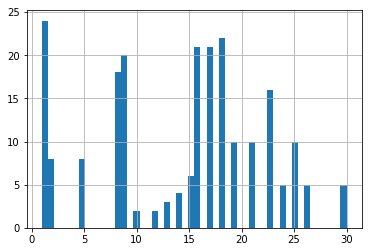

In [6]:
data_train = data_v4[benchmark_training]
data_train['Latency'].hist(bins=50)
plt.show()

In [83]:
for i in benchmarks:
    print(i)
    print(direct_mapping(data_v4[i]))

adpcm_encoder
(0.025068972835314091, 0.097782258064516125, 0.27220855398845356, 0.6666666666666666, 6)
average
(0.0, 0.0, 0.45261815117631948, 1.0, 8)
fir
(0.0, 0.0, 0.33772354972910351, 1.0, 5)


adpcm_encoder


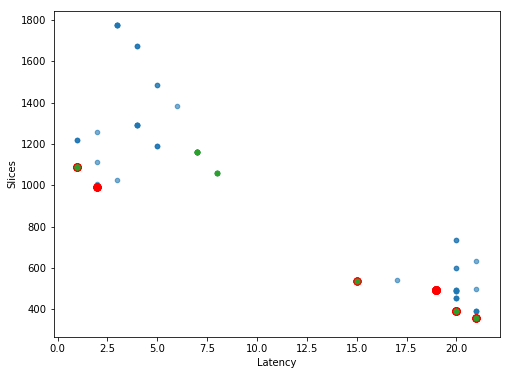

average


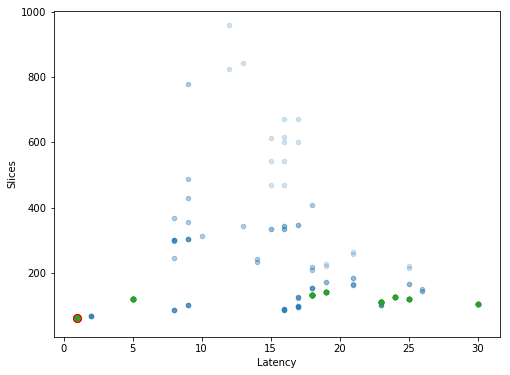

fir


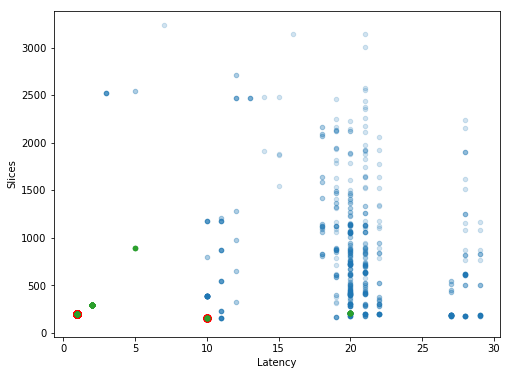

In [122]:
for i in benchmarks:
    print(i)
    visulize_trade_off(data_v4[i])
    plt.show()

In [7]:
# split data
strat_train_set, strat_test_set = stratify_split_data(data_train, data_train['Latency'])

In [8]:
corr_matrix = strat_train_set.corr()
corr_matrix['Slices'].sort_values(ascending=False)

Slices      1.000000
MUX         0.944143
pin_pair    0.930833
AREA        0.866169
net         0.854798
FU          0.470955
REG         0.464283
Latency     0.014650
FU.1       -0.037590
state      -0.044237
ave        -0.061036
min        -0.061036
max        -0.061036
MISC       -0.089144
DEC        -0.188023
Name: Slices, dtype: float64

In [9]:
X_train = strat_train_set.drop(['Latency'], axis=1)
y_train = strat_train_set['Slices'].copy()

In [10]:
# select features
features = select_features(X_train, 'Slices', 0)
features

['MUX', 'pin_pair', 'AREA', 'net', 'FU', 'REG']

In [ ]:
X_train

In [ ]:
# deal with missing values
# from sklearn.preprocessing import Imputer
# imputer = Imputer(strategy='median')

# feature_num = list(corr_matrix.keys())
# feature_num.remove('Slices')
# feature_num.remove('DEC')
# X_train_num = X_train[feature_num]
# imputer.fit(X_train_num)

# X_train_num_transformed = imputer.transform(X_train_num)

# X_train_num_tr = pd.DataFrame(X_train_num_transformed, columns=X_train_num.columns)

In [11]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_num_tr_scaled = scaler.fit_transform(X_train[features])

In [ ]:
# Or use pipeline for the above preprocessing
# from sklearn.pipeline import Pipeline
# num_pipeline = Pipeline([
#     ('imputer', Imputer(strategy='median')),
#     ('std_scaler', StandardScaler()),
# ])
# X_train_num_tr_scaled = num_pipeline.fit_transform(X_train_num)

In [12]:
X_train_prepared = X_train_num_tr_scaled.copy()

In [51]:
# select and train a model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
measure_rmse(lin_reg, X_train_prepared, y_train)

26.424066907024194

In [47]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)
measure_rmse(tree_reg, X_train_prepared, y_train)

0.0

In [24]:
scores_cv = measure_cv(lin_reg, X_train_prepared, y_train)

Scores: [ 32.83  19.32  26.26  22.06  34.28  36.9   31.9   30.36  24.01  14.23]
Mean: 27.2159630854
Standard deviation: 6.89807465206


In [29]:
scores_cv = measure_cv(tree_reg, X_train_prepared, y_train)

Scores: [ 17.33  29.83   2.36   1.94   4.64  33.67  35.41  12.66  20.46  19.25]
Mean: 17.7548852967
Standard deviation: 11.8553370015


In [32]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
scores_cv = measure_cv(forest_reg, X_train_prepared, y_train)

Scores: [ 25.8   47.43   3.78  11.92   7.34  38.54  28.79  14.63  14.25  16.68]
Mean: 20.9154407846
Standard deviation: 13.2667810932


In [67]:
forest_reg.fit(X_train_prepared, y_train)
measure_rmse(forest_reg, X_train_prepared, y_train)
# forest_reg.feature_importances_

8.4401401593273864

In [37]:
# fine tune the model
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [38]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 10}

In [53]:
measure_rmse(grid_search.best_estimator_, X_train_prepared, y_train)

8.7669446320721178

In [68]:
# testing
X_test = strat_test_set[features].copy()
y_test = strat_test_set['Slices'].copy()

In [69]:
X_test_prepared = scaler.fit_transform(X_test)

In [70]:
measure_rmse(forest_reg, X_test_prepared, y_test)

45.280160716868643

In [73]:
X_test = data_v4['adpcm_encoder'][features].copy()
y_test = data_v4['adpcm_encoder']['Slices'].copy()

In [74]:
X_test_prepared = scaler.fit_transform(X_test)

In [77]:
print(y_test.median())
print(measure_rmse(forest_reg, X_test_prepared, y_test))

736.0
786.565034596
